In [52]:
# Import all the necessary libraries.
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import math

%matplotlib inline

In [53]:
# Always reset the pseudo random number generator to the same number.
np.random.seed(1012019)

# Define the number of examples.
M = 1000

# Generate target function.
x1 = np.random.randn(M, 1)
x2 = np.random.randn(M, 1)
y = x1 + x2 + np.random.randn(M, 1)

In [54]:
# Generate values for parameters.
N = 200
a1 = np.linspace(-12.0, 14.0, N)
a2 = np.linspace(-12.0, 14.0, N)

A1, A2 = np.meshgrid(a1, a2)

# Generate points for plotting the cost-function surface.
J = np.zeros((N,N))
for iter1 in range(0, N):
    for iter2 in range(0, N):
        yhat = A1[iter1][iter2]*x1 + A2[iter1][iter2]*x2
        J[iter1][iter2] = (1.0/M)*np.sum( np.square(y - yhat))

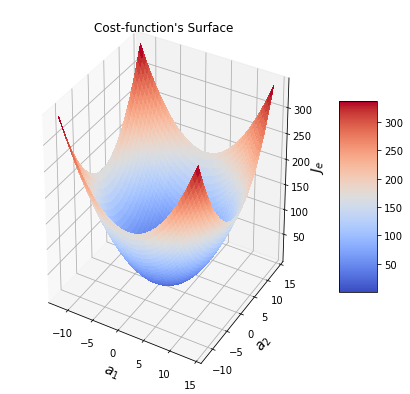

In [55]:
# Plot cost-function surface.
fig = plt.figure(figsize=(7,7))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(A1, A2, J, cmap=cm.coolwarm, linewidth=0, antialiased=False)
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
ax.set_xlabel('$a_1$', fontsize=14)
ax.set_ylabel('$a_2$', fontsize=14)
ax.set_zlabel('$J_e$', fontsize=14)
plt.title('Cost-function\'s Surface')
#plt.savefig("error_surface_sgd_ls.png", dpi=600)
#Show the plot.
plt.show()

In [56]:
# Concatenate both column vectors, x1 and x2.
X = np.c_[x1, x2]

# Closed-form solution.
a_opt = np.linalg.pinv(np.transpose(X).dot(X)).dot(np.transpose(X).dot(y))
yhat = X.dot(a_opt)
Joptimum = (1.0/M)*np.sum(np.power((y - yhat), 2))

In [57]:
# Number of epochs.
n_epochs = 1
# Constant learning rate.
alpha_int = 0.3

# learning schedule: Decaimento temporal
def timeBasedDecay(alpha_int, k, t):
    return alpha_int / (1 + k*t)

# learning schedule: Exponential Decay.
def exponentialDecay(alpha_int, k, t):
    return alpha_int * np.exp(-k*t)

def stepDecay(alpha_int, t):
    drop = 0.5
    epochs_drop = 4.0
    alpha = alpha_int * math.pow(drop, math.floor((1+t)/epochs_drop))
    return alpha

#k = 0.1 #(exp)
k = 0.01
# Momentum
mu = 0.1
def learning_schedule(typels, alpha_int, k, t):
    mu = 0
    if(typels=='exp'):
        alpha = exponentialDecay(alpha_int, k, t)
    elif(typels=='time'):
        alpha = timeBasedDecay(alpha_int, k, t)
    elif(typels=='step'):
        alpha = stepDecay(alpha_int, t)
    elif(typels=='mom'):
        alpha = alpha_int
        mu = mu
    elif(typels=='none'):
        alpha = alpha_int
    else:
        alpha = alpha_int
    return alpha, mu

In [58]:
# Random initialization of parameters.
a = np.array([-10.0, -10.0]).reshape(2, 1)

# Create vector for parameter history.
a_hist = np.zeros((2, n_epochs*M+1))
# Initialize history vector.
a_hist[:, 0] = a.reshape(2,)

# Create vector to store eta history.
alpha_hist = np.zeros((n_epochs*M))

update_prev = np.zeros((2, 1))

# Create array for storing error values.
Jgd = np.zeros(n_epochs*M+1)

Jgd[0] = (1.0/M)*sum(np.power(y - X.dot(a), 2))

# Stocastic gradient-descent loop.
update_hist = np.zeros((2, n_epochs*M))
for epoch in range(n_epochs):
    for i in range(M):
        random_index = np.random.randint(M)
        xi = X[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = -2.0*xi.T.dot(yi - xi.dot(a))      
        alpha, mu = learning_schedule('step', alpha_int, k, epoch*M + i)
        alpha_hist[epoch*M+i] = alpha
        update = alpha*gradients + mu*update_prev
        update_hist[:, epoch*M+i] = update.reshape(2,) 
        a = a - update
        a_hist[:, epoch*M+i+1] = a.reshape(2,)
        update_prev = update
        Jgd[epoch*M+i+1] = (1.0/M)*sum(np.power((y - X.dot(a)) , 2))

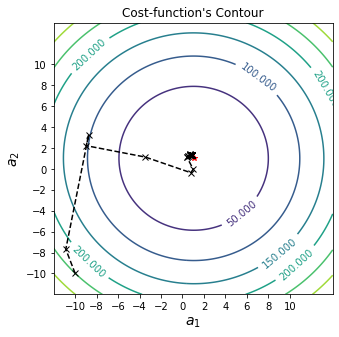

In [59]:
# Plot figure.        
fig = plt.figure(figsize=(5,5))
cp = plt.contour(A1, A2, J)
plt.clabel(cp, inline=1, fontsize=10)
plt.xlabel('$a_1$', fontsize=14)
plt.ylabel('$a_2$', fontsize=14)
plt.title('Cost-function\'s Contour')
plt.plot(a_opt[0], a_opt[1], c='r', marker='*')
plt.plot(a_hist[0, :], a_hist[1, :], 'kx--')
plt.xticks(np.arange(-10, 12, step=2.0))
plt.yticks(np.arange(-10, 12, step=2.0))
#plt.savefig("error_contour_sgd_ls.png", dpi=600)
plt.show()

In [60]:
# Print found values.
print('a0_opt: ' + str(a_opt[0, 0]))
print('a1_opt: ' + str(a_opt[1, 0]))

print('a0_sgd: ' + str(a[0, 0]))
print('a1_sgd: ' + str(a[1, 0]))

a0_opt: 1.039131461823306
a1_opt: 1.019522855508551
a0_sgd: 0.8705190479299831
a1_sgd: 1.300797634698687


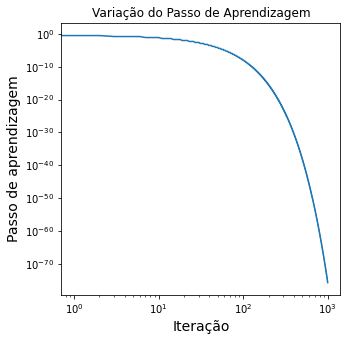

In [61]:
# Plot alpha history     
fig = plt.figure(figsize=(5,5))
plt.plot(range(0,n_epochs*M), alpha_hist)
plt.yscale("log")
plt.xscale("log")
plt.xlabel('Iteração', fontsize=14)
plt.ylabel('Passo de aprendizagem', fontsize=14)
plt.title('Variação do Passo de Aprendizagem')
#plt.savefig("passo_de_aprendizagem.png", dpi=600)
plt.show()

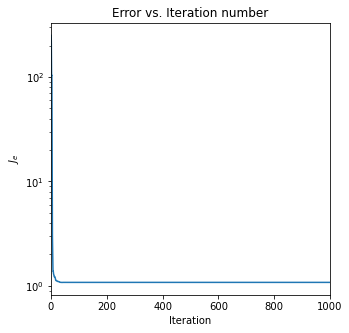

In [62]:
fig = plt.figure(figsize=(5,5))

plt.plot(np.arange(0, n_epochs*M), Jgd[0:n_epochs*M])
plt.xlim((0, n_epochs*M))
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('$J_e$')
plt.title('Error vs. Iteration number')
#plt.savefig("error_vs_iteration_sgd_ls.png", dpi=600)
plt.show()

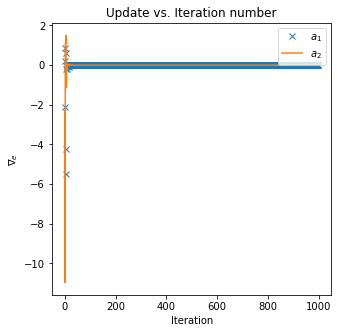

In [63]:
fig = plt.figure(figsize=(5,5))

plt.plot(np.arange(0, n_epochs*M), update_hist[0,:], 'x', label='$a_1$')
plt.plot(np.arange(0, n_epochs*M), update_hist[1,:], label='$a_2$')
plt.xlabel('Iteration')
plt.ylabel('$\\nabla_e$')
plt.title('Update vs. Iteration number')
plt.legend()
plt.show()